# パッケージのインストール

In [ ]:
!pip install umap-learn
!pip install japanize-matplotlib
!pip install plotly umap-learn
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=080662af8ba0e84f23a8c22a0c0069303de9e2121c2a0d068f6843d2a51afb0a
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


# 必要な関数

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import nltk
import re
from nltk.corpus import stopwords
import os
from mpl_toolkits.mplot3d import Axes3D  # 3次元プロット用
import umap.umap_ as umap
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import japanize_matplotlib
from collections import Counter
from transformers import AutoTokenizer, AutoModel
import torch
from gensim.models import FastText
from wordcloud import WordCloud
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import plotly.io as pio
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
journal_colors = {
    'SciMet': '#000080',  # ネイビー
    'SSS': '#ff7f0e',  # オレンジ
    'RePoli': '#2ca02c',  # 緑
    'STHV': '#d62728',  # 赤
    'TechNov': '#9467bd',  # 紫
    'PUS': '#8c564b',  # 茶
    'Minerva': '#e377c2',  # ピンク
    'SciCom': '#7f7f7f',  # グレー
    'SasC': '#bcbd22',  # 黄緑
    'ReEval': '#17becf',  # 水色
    'STS': '#ff9896',  # ピンク
    'JRI': '#1f77b4',  # 青
    'EASTS': '#ffbb78',  # ピーチ
    'TIS': 'teal',  # ディール
    'SPP': 'olive',  # オリーブ
    'JCOM': 'darkolivegreen'  # ダークグリーン
}

# データ取得(初回のみ)

In [ ]:
%pip install pyalex
from pyalex import Works, Authors, Sources, Institutions,Topics, Concepts, Funders
import pyalex,pandas as pd, numpy as np, matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import random,time,itertools,tqdm,collections
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
import re
import nltk
import pandas
import tqdm
import requests
from bs4 import BeautifulSoup
import pickle

flatten = lambda x: list(itertools.chain.from_iterable(x))

pyalex.config.email = "miyabe-hiroki806@g.ecc.u-tokyo.ac.jp" # ここにあなたのメールアドレスを入力してください

from pyalex import config

config.max_retries = 3  # 最大再試行数を 3 回に設定
config.retry_backoff_factor = 1  # 再試行間隔を 0.1 秒に設定
config.retry_http_codes = [429, 500, 503]  # 再試行を行う HTTP エラーコードを指定

In [ ]:
def getAll(pyalexObj):
    pager = pyalexObj.paginate(per_page=200,n_max=None)
    arr = []
    for page in tqdm.tqdm(pager):
        arr += page
    return arr

def get_tab20_color_hex(index):
    if index!=index:
        return None
    cmap = plt.get_cmap('tab20')
    actual_index = index % 20
    rgb_color = cmap(int(actual_index))[:3]  # Ignore the alpha value
    hex_color = '#%02x%02x%02x' % (int(rgb_color[0]*255), int(rgb_color[1]*255), int(rgb_color[2]*255))
    return hex_color

def get_journal_name_original(citing):
    '''
    citnig(列)：['primary_location']列しか取れない

    '''
    try:
        return citing['source']['display_name']
    except:
        return None

def get_topic(topic_raw,class_):
    '''
    topic()：['primary_location']列しか取れない
    class(str):domain,field,subfieldから選ぶ
    '''

    if class_ == "domain":
        try:
          return topic_raw['domain']["display_name"]

        except:
          return None

    elif class_ == "field":
        try:
          return topic_raw['field']["display_name"]

        except:
          return None

    elif class_ == "subfield":

        try:
         return topic_raw['subfield']["display_name"]

        except:
          return None



def remove_parentheses(text):
    """
    文字列から()で囲まれた部分を含む文字列を削除し、
    ()の前に半角スペースがある場合、そのスペースも削除する関数

    Parameters:
        text (str): 対象の文字列

    Returns:
        str: ()で囲まれた部分が削除された文字列
    """
    return re.sub(r'\s*\([^()]*\)', '', text)

def remove_parentheses(text):
    # 正規表現を使って()で囲まれた部分を検索し、削除する
    result = re.sub(r'\([^)]*\)', '', text)
    return result.strip()  # 削除後に余分な空白を削除して返す

def fetch_json_data(url):

    retries = 5

    '''
    url(str):APIのURL
    json_data(json):論文のデータ
    '''

    for _ in range(retries):

      try:
          response = requests.get(url)
          # ステータスコードが200以外の場合はエラーを発生させます
          response.raise_for_status()
          # JSONデータを取得します
          json_data = response.json()

          break

      except Exception as e:
            print(f"エラーが発生しました: {e}")
            print("リトライします...")
            time.sleep(5)
            continue

    return json_data


def fetch_all_results(url):
    url += "&per-page=200"
    results = []

    # リトライ回数
    retries = 5

    for _ in range(retries):
        try:
            # 初回のリクエストでカーソルを取得
            response = requests.get(url + "&cursor=*")
            data = response.json()

            # レスポンスから結果を取得
            if "results" in data:
                results += data["results"]

            # ページング情報を更新
            while "meta" in data and "next_cursor" in data["meta"]:
                next_cursor = data["meta"]["next_cursor"]
                response = requests.get(url + f"&cursor={next_cursor}")
                data = response.json()

                # レスポンスから結果を取得
                if "results" in data:
                    results += data["results"]

            # エラーが起きなかった場合はループを抜ける
            break
        except Exception as e:
            print(f"エラーが発生しました: {e}")
            print("リトライします...")
            time.sleep(5)
            continue

    return results




#journal
def get_journal_topic(url):
  api_url = "https://api.openalex.org/works/" + url.split("/")[-1]
  inf = fetch_json_data(api_url)
  journal = get_journal_name_original(inf["primary_location"])
  #たまにtopic列がないやつの方があるからtry文をかませる
  try:
    field = get_topic(inf["primary_topic"], class_="field")
    subfield = get_topic(inf["primary_topic"], class_="subfield")
  except Exception as error:
      field = None
      subfield = None

  return journal, field, subfield
# 指定されたcovid_wordsのリスト



# NLTKのインストールとストップワードのダウンロードは省略します
# カスタムストップワードリスト
custom_stopwords = [
    "abstract","abstracts","result","results","study","studies","science","scientists","scientist","scientists","research","researchers","researcher","researchers",
    "analysis","finding","findings","finding","findings","find","suggest","indicate","show","propose","discuss",
    "one","two","three","four","five","six","seven","eight","nine","ten",
    "first","second","third","fourth","fifth","sixth","seventh","eighth","ninth","tenth",
    "can", "could", "may", "might", "must", "need", "ought", "shall", "should", "will","would","have","has","had","do","does","did","doing","done",
    "i", "you", "he", "she", "it", "we", "they",
    "me", "you", "him", "her", "us", "them",
    "my", "your", "his", "her", "its", "our", "their",
    "mine", "yours", "hers", "ours", "theirs",
    "this", "that", "these", "those",
    "here", "there",
    "on", "in", "at", "by", "with", "about", "for", "of", "to", "from", "up", "down", "over", "under",
    "after", "before", "while", "during", "since", "around", "through","as","towords","within","among"
    "very", "really", "quite", "too", "enough", "so", "thus", "therefore", "however", "nevertheless", "moreover",
    "and", "or", "but", "nor", "yet", "such",
    "today","tomorrow","yesterday","month","year","week","day","hour","minute","second","time","date","now",
    "because","though","although","unless","until","until",
    "a","the","an",
    "who","what","when","where","why","how","which","whom","whose",
    "some","any","both","either","evert","neither","no","none","not"
    "most","much","many","almost","few","little","well","also","ways",
    "someone","anyone","everyone","noone","nothing","nobody","anything","something","thing"
    "am", "is", "are", "was", "were","be","been","being",
    "probably", "always", "often", "frequently", "generally", "usually",
    "occasionally", "sometimes", "rarely", "seldom", "never",
    "possibly", "potentially", "likely", "perhaps"
]


def stem_words(word_dict):
    cleaned_words = []
    ps = PorterStemmer()

    for word, positions in word_dict.items():
        # 1. 単語の小文字化
        word = word.lower()

        # 2. 単語の正規化
        # 2.1 '+s, '+ll, '+re, '+ve, '+d の削除
        word = re.sub(r"'\b(s|ll|re|ve|d)\b", "", word)

        # 2.2 記号の削除(""や[]や {}や()や . や,など)
        word = re.sub(r'[\"\'\[\]\{\}\.,;:!?\❝❞―]', '', word)

        # 2.3 数字を含む単語の削除 (19を含む単語は除外)
        if re.search(r'\d', word) and '19' not in word:
            continue

        # 括弧やハイフンで単語を分割して追加
        word_parts = re.split(r'[()\[\]{}-―]', word)
        cleaned_parts = []
        for part in word_parts:
            if part.strip():
                cleaned_parts.extend(part.split())  # スペースで分割して追加

        # ステミングを適用
        stemmed_words = [ps.stem(part) for part in cleaned_parts if part.strip() and part not in custom_stopwords]

        for pos in positions:
            if stemmed_words:
                cleaned_words.append((stemmed_words[0], pos))

    # 単語を元の順序で並べる
    ordered_words = sorted(cleaned_words, key=lambda x: x[1])
    cleaned_text = ' '.join([word for word, pos in ordered_words])

    return cleaned_text


def prepare_stopwords(custom_stopwords):
    # NLTKのストップワードをダウンロード（必要な場合）

    nltk.download('stopwords')

    # NLTKのストップワードを取得
    nltk_stopwords = set(stopwords.words('english'))

    # NLTKのストップワードに自前のストップワードを追加
    combined_stopwords = nltk_stopwords.union(set(custom_stopwords))

    return combined_stopwords

def clean_and_order_words(word_dict,combined_stopwords):
    # ストップワードの準備

    cleaned_words = []

    for word, positions in word_dict.items():
        # 単語の小文字化
        word = word.lower()

        # 単語の正規化
        # '+s, '+ll, '+re, '+ve, '+d の削除
        word = re.sub(r"'\b(s|ll|re|ve|d)\b", "", word)

        # 括弧や中身の削除
        word = re.sub(r'\(.*?\)', '', word)
        word = re.sub(r'\[.*?\]', '', word)
        word = re.sub(r'\{.*?\}', '', word)

        # 記号の削除 (string.punctuationを使用)
        word = word.translate(str.maketrans('', '', string.punctuation))

        # 数字を含む単語の削除 (19を含む単語は除外)
        if re.search(r'\d', word) and '19' not in word:
            continue

        # 単語の分割
        cleaned_parts = word.split()  # スペースで分割して追加

        # ストップワードを除外
        cleaned_words.extend([(part, pos) for part in cleaned_parts if part.strip() and part not in combined_stopwords for pos in positions])

    # 単語を元の順序で並べる
    ordered_words = sorted(cleaned_words, key=lambda x: x[1])
    cleaned_text = ' '.join([word for word, pos in ordered_words])

    return cleaned_text

# 省略可能

In [ ]:
cols = ["id","authorships",'title',"publication_year","referenced_works","cited_by_count","primary_topic","primary_location","abstract_inverted_index"]

source_ids = [
    ##STS系
    "https://openalex.org/sources/s202144432", # Science, technology & society
    "https://openalex.org/sources/s2181421",   # Science, technology & human values
    "https://openalex.org/sources/s68632876",  # Social studies of science
    "https://openalex.org/sources/s104981805", # East Asian science, technology and society
    "https://openalex.org/sources/s190143089", # Science as culture
    "https://openalex.org/sources/s205537954", # Minerva
    #コミュニケーション系
    "https://openalex.org/sources/s124907306", # Public understanding of science
    "https://openalex.org/sources/s30803906",  # JCOM, journal of science communication
    "https://openalex.org/sources/s4210212669",# Science communication
    #計量系
    "https://openalex.org/sources/s16793705",  # Research Evaluation
    "https://openalex.org/sources/s9731383",   # Research policy
    "https://openalex.org/sources/s4210168539",# Science and public policy
    "https://openalex.org/sources/s148561398", # scientometorics
    #テクノロジー
    "https://openalex.org/sources/s70698675",  # technovation
    "https://openalex.org/sources/s149100181", # Technology in society
    "https://openalex.org/sources/s2764399430" # Journal of Responsible Innovation


]

In [ ]:
#全てのSTS論文
THRESHOLD = 0
pyalexObj = Works().filter(locations={"source":{"id":"|".join(source_ids)}}, cited_by_count=f">{THRESHOLD-1}",has_references="true").select(cols)
field_count = pyalexObj.count()
print(field_count)
works =  pd.DataFrame(getAll(pyalexObj)).drop_duplicates(subset=['id'])
print(f"取得した論文数/分野内の論文数：{len(works)}/{field_count} ({round(len(works)/field_count*100,2)}%)" )



27473


139it [02:48,  1.21s/it]


取得した論文数/分野内の論文数：25588/27473 (93.14%)


In [ ]:
works["journal_name"] = works["primary_location"].apply(get_journal_name_original).apply(remove_parentheses)


AttributeError: 'Series' object has no attribute 'count_data'

In [ ]:
df["journal_name"].value_counts()

,count
journal_name,
RePoli,3962
TechNov,2474
TIS,2314
SciMet,1889
SSS,1364
PUS,1281
STHV,1162
SPP,1140
SciCom,744


In [ ]:
def get_author(authorship_col):
    author_list = []
    for auth in authorship_col:
        author_list.append(auth['author']['display_name'])
    return author_list

In [ ]:
#ジャーナル名を省略する
df = works.copy()

df.loc[df['journal_name'] == 'Social Studies of Science', 'journal_name'] = 'SSS'

df.loc[df['journal_name'] == 'Science, technology & human values/Science, technology, & human values', 'journal_name'] = 'STHV'

df.loc[df['journal_name'] == 'Science Technology & Human Values', 'journal_name'] = 'STHV'

df.loc[df['journal_name'] == 'Public Understanding of Science', 'journal_name'] = 'PUS'

df.loc[df['journal_name'] == 'Science as Culture', 'journal_name'] = 'SasC'

df.loc[df['journal_name'] == 'Research Policy', 'journal_name'] = 'RePoli'

df.loc[df['journal_name'] == 'Science Technology and Society', 'journal_name'] = 'STS'

df.loc[df['journal_name'] == 'Research Evaluation', 'journal_name'] = 'ReEval'

df.loc[df['journal_name'] == 'East Asian Science Technology and Society An International Journal', 'journal_name'] = 'EASTS'

df.loc[df['journal_name'] == 'Science Communication', 'journal_name'] = 'SciCom'

df.loc[df['journal_name'] == 'Journal of Responsible Innovation', 'journal_name'] = 'JRI'

df.loc[df['journal_name'] == 'Journal of responsible innovation', 'journal_name'] = 'JRI'

df.loc[df['journal_name'] == 'Technology in Society', 'journal_name'] = 'TIS'

df.loc[df['journal_name'] == 'Science and Public Policy', 'journal_name'] = 'SPP'

df.loc[df['journal_name'] ==  'Journal of Science Communication', 'journal_name'] = 'JCOM'

df.loc[df['journal_name'] ==  'Scientometrics', 'journal_name'] = 'SciMet'

df.loc[df['journal_name'] ==  'Technovation', 'journal_name'] = 'TechNov'

df = df.dropna(subset=['id','title','abstract_inverted_index',"journal_name"])

In [ ]:
# 例のテキストデータ
texts = df["abstract_inverted_index"].to_list()

#ストップワードの準備
combined_stopwords = prepare_stopwords(custom_stopwords)
# クリーニングしたテキストを取得
cleaned_texts = [clean_and_order_words(text, combined_stopwords) for text in texts]

df["text_strings"] = cleaned_texts
df["authorships"] = df["authorships"].apply(get_author)

os.chdir("/content/drive/MyDrive/卒論/STS_ALL")
df.to_json("STS_All.json", orient="records")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
cooccurrence_counter

Counter({'reaching': 1,
         'better': 21,
         'understanding': 60,
         'policies': 27,
         'politics': 12,
         'transitions': 11,
         'presents': 16,
         'main': 25,
         'agenda': 17,
         'item': 2,
         'emerging': 34,
         'field': 119,
         'sustainability': 21,
         'one': 68,
         'important': 53,
         'requirement': 1,
         'such': 106,
         'as': 422,
         'move': 7,
         'towards': 25,
         'decarbonized': 1,
         'energy': 17,
         'system': 36,
         'redirection': 1,
         'acceleration': 1,
         'technological': 39,
         'change': 49,
         'which': 152,
         'play': 7,
         'key': 32,
         'role': 58,
         'regard': 5,
         'several': 22,
         'studies': 146,
         'have': 167,
         'argued': 9,
         'need': 42,
         'combine': 3,
         'different': 126,
         'policy': 130,
         'instruments': 7,
         'so': 

# Word2Vec


# FastText

In [ ]:
# SIF重みを計算する関数
def sif_weight(word, a=1e-3):
    p_word = word_counts[word] / total_words
    return a / (a + p_word)

all_df = pd.read_json("/content/drive/MyDrive/卒論/STS_ALL/STS_All.json", orient="records")
all_df = all_df.drop(['referenced_works', 'cited_by_count',
        'primary_location', 'abstract_inverted_index',] ,axis=1)
all_df['primary_topic'] = all_df['primary_topic'].apply(lambda x: get_topic(x, 'subfield'))

#年代ごとにdfを分割
df_1990s = all_df[(all_df["publication_year"] > 1990) & (all_df["publication_year"] < 1996)]
df_1995s = all_df[(all_df["publication_year"] > 1995) & (all_df["publication_year"] < 2001)]
df_2000s = all_df[(all_df["publication_year"] > 2000) & (all_df["publication_year"] < 2006 )]
df_2005s = all_df[(all_df["publication_year"] > 2005) & (all_df["publication_year"] < 2011)]
df_2010s = all_df[(all_df["publication_year"] > 2010) & (all_df["publication_year"] < 2016)]
df_2015s = all_df[(all_df["publication_year"] > 2015) & (all_df["publication_year"] < 2021) ]
df_2020s = all_df[all_df["publication_year"] > 2020]# 10年区切りのデータフレームを作成

train_df = all_df
train_sentences = [text.split() for text in train_df['text_strings']]
test_df_lst = [df_1990s, df_1995s, df_2000s, df_2005s, df_2010s, df_2015s, df_2020s]


In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from gensim.models import FastText
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from scipy.stats import zscore

In [ ]:
os.chdir("/content/drive/MyDrive/卒論/STS_ALL/results")

## モデル

In [ ]:
from gensim.models import FastText

years = [1990,1995, 2000, 2005, 2010, 2015, 2020]
test_dfs = []
tranin_sentences = [text.split() for text in train_df['text_strings']]
fasttext_model = FastText(tranin_sentences, vector_size=300, window=10, min_count=1, workers=4)

In [ ]:
fasttext_model.save("fasttext_model.bin")

# IQR version

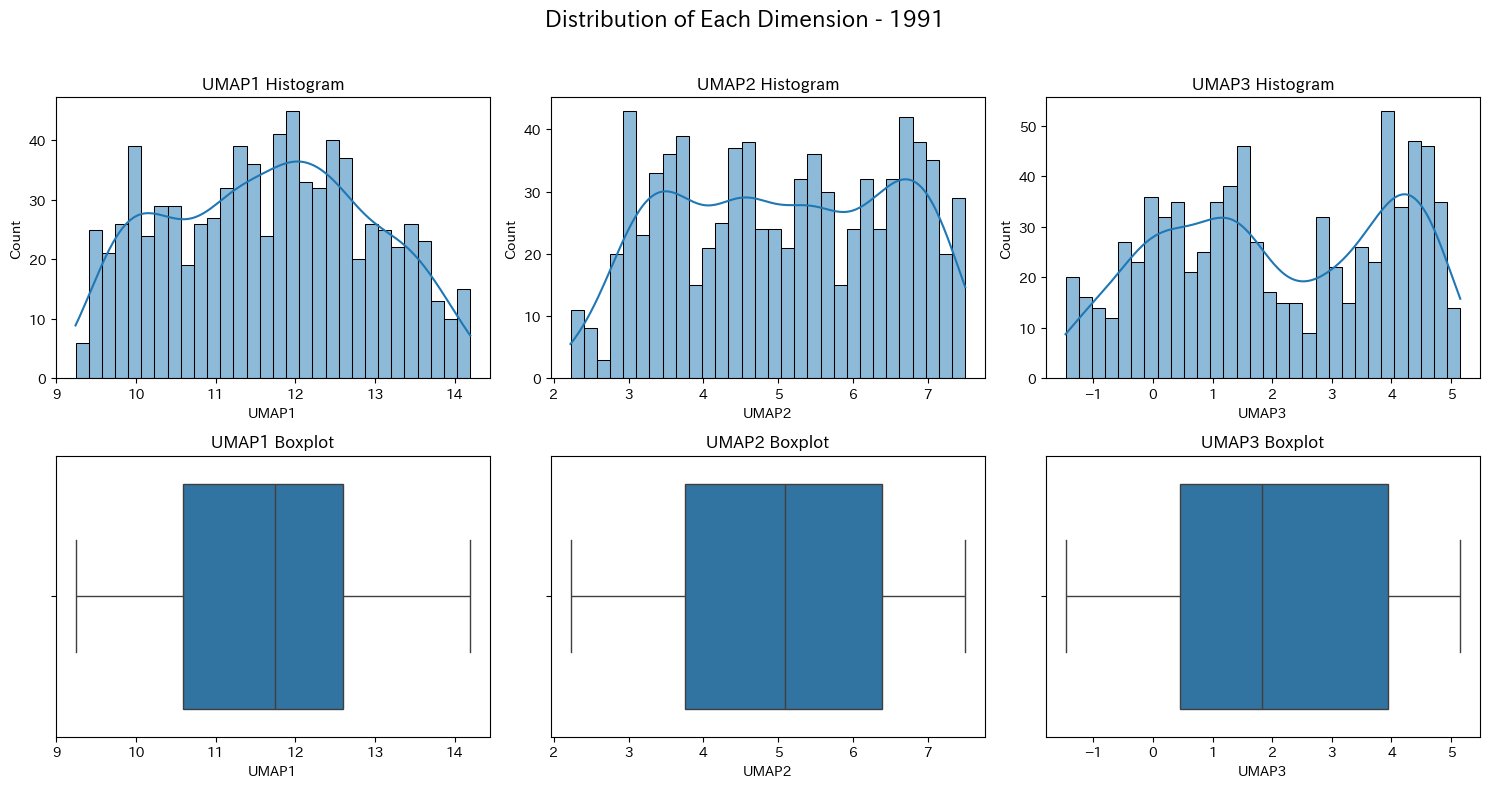

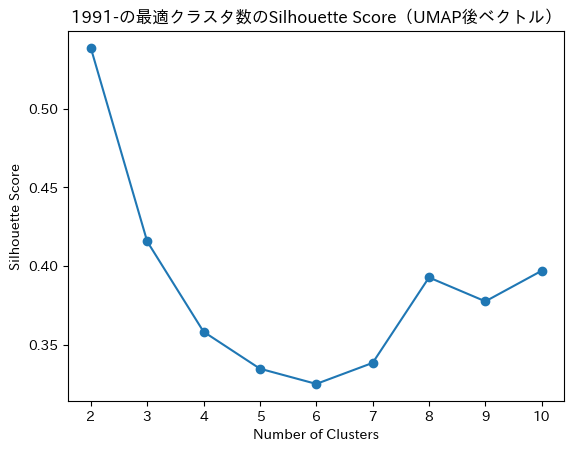

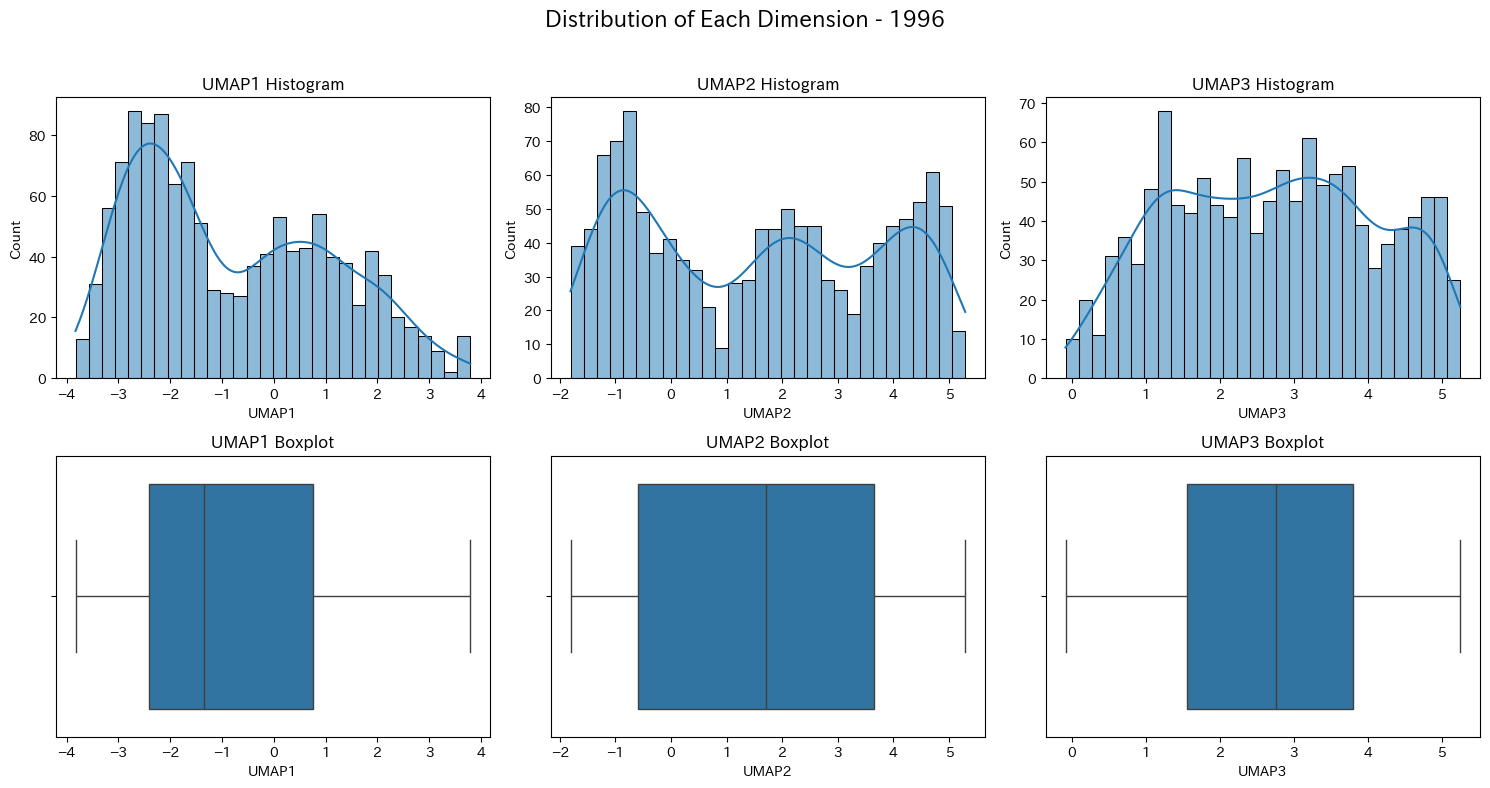

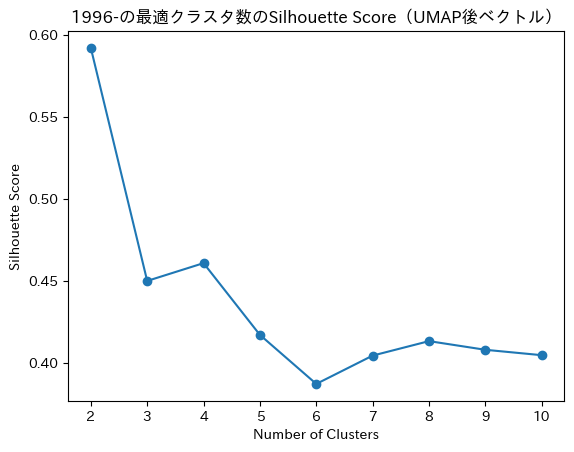

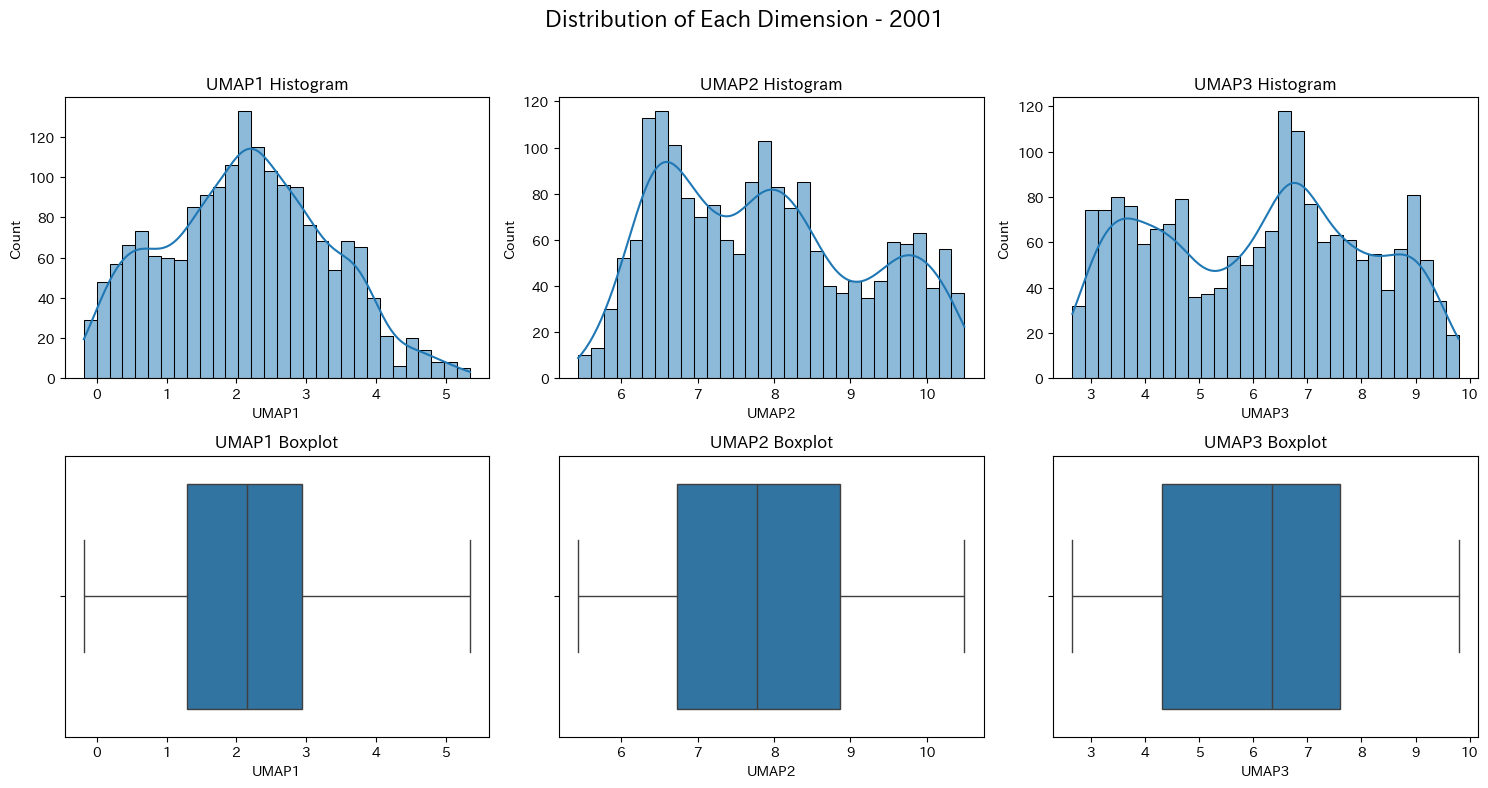

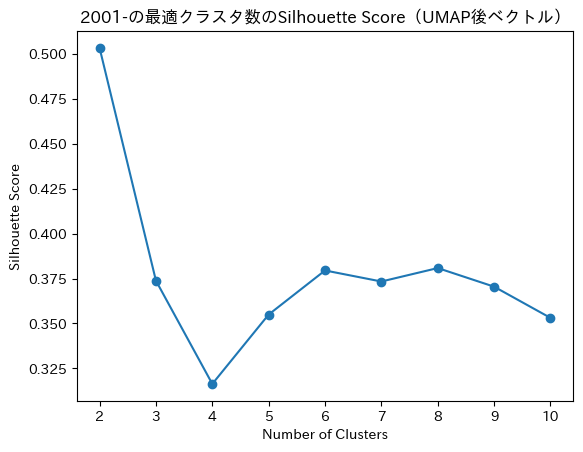

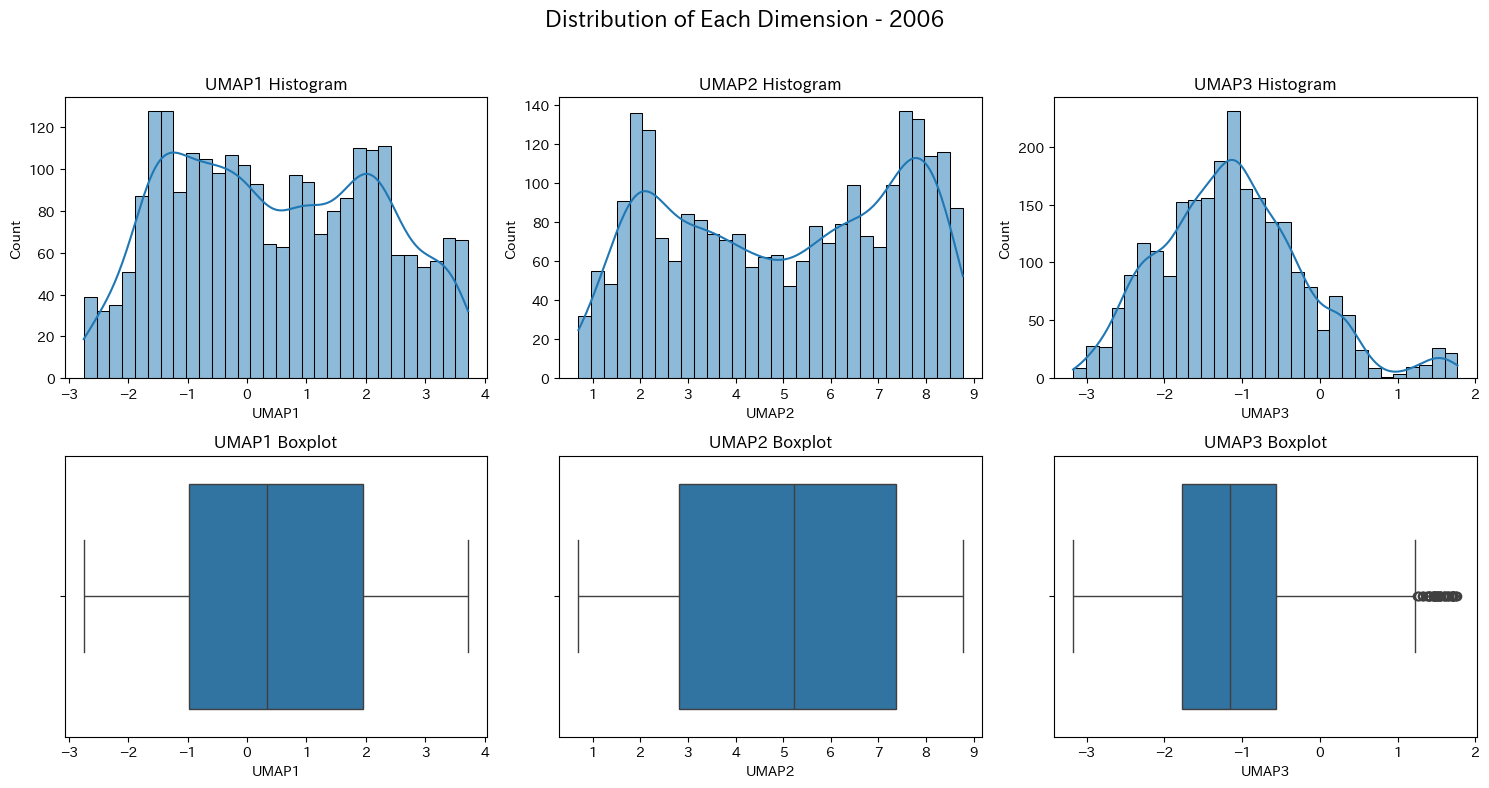

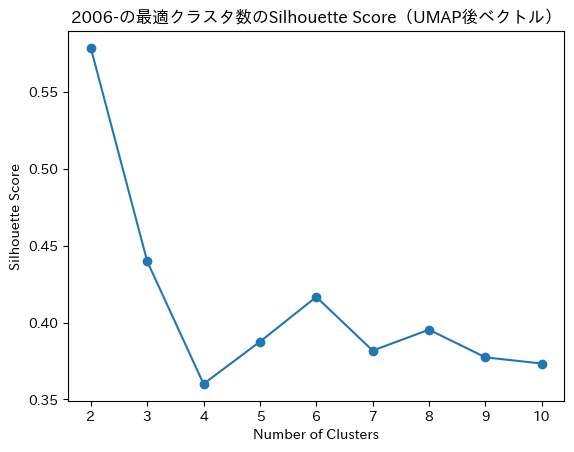

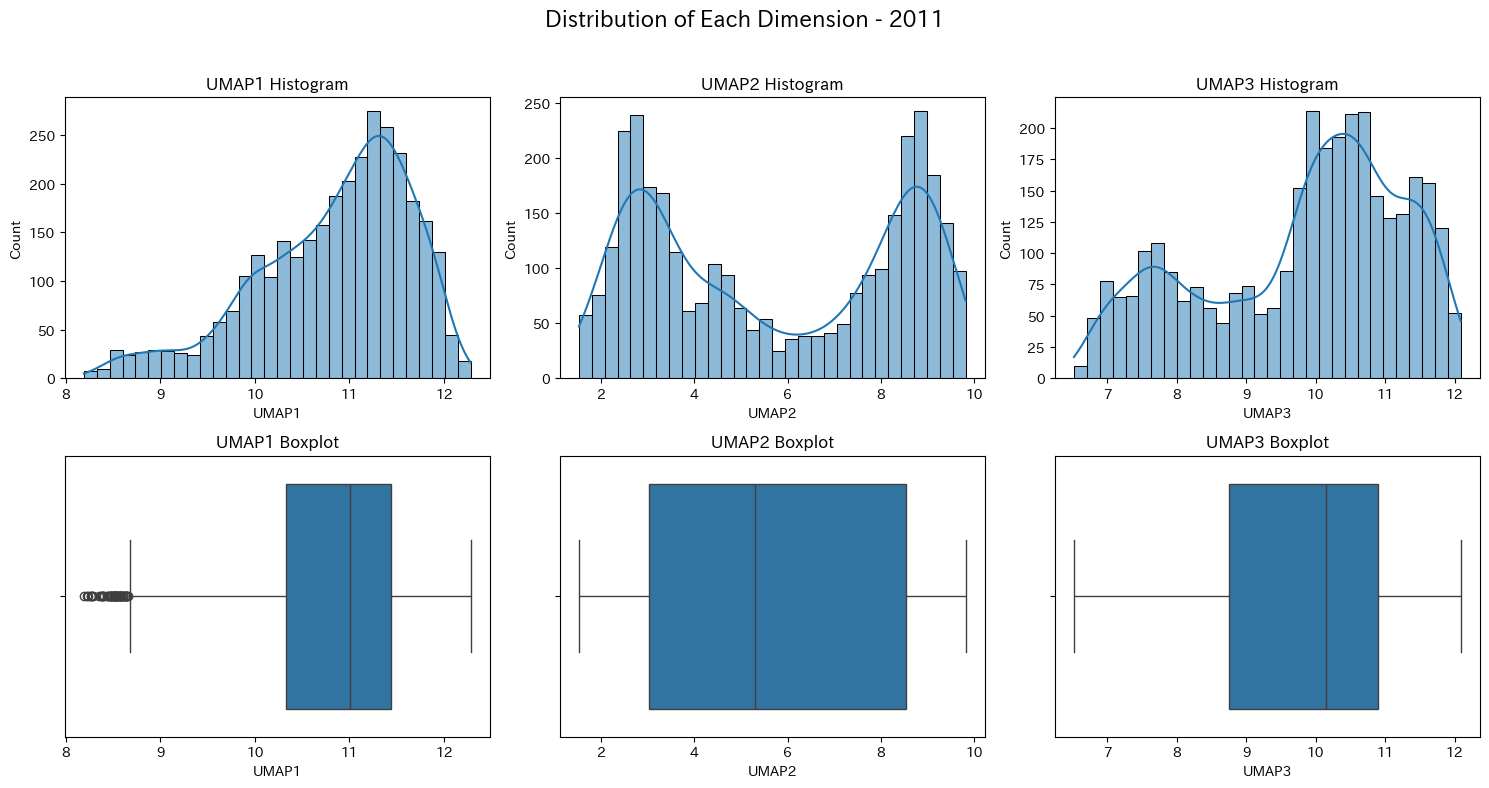

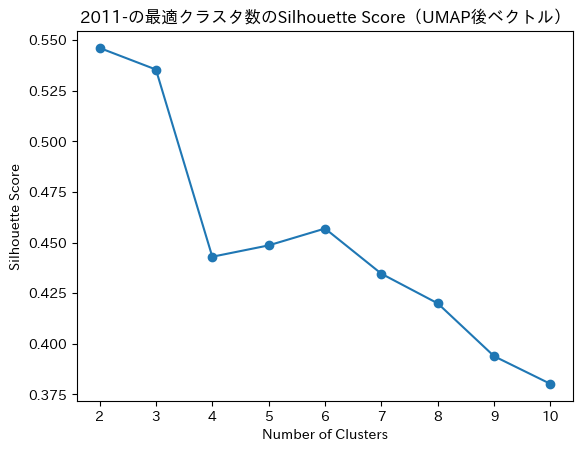

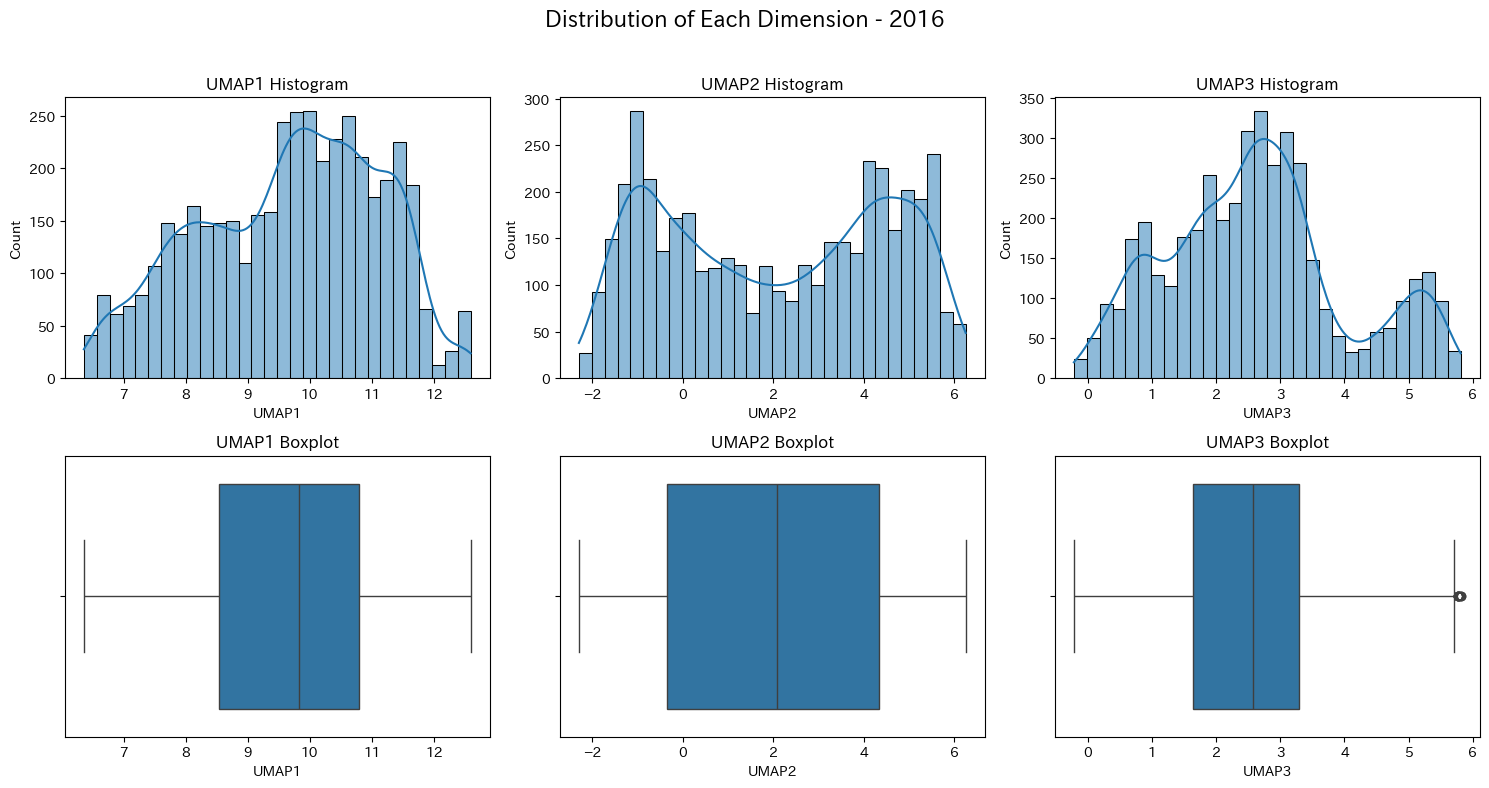

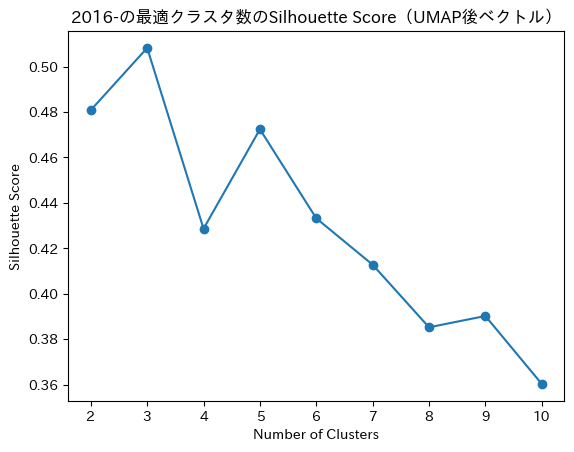

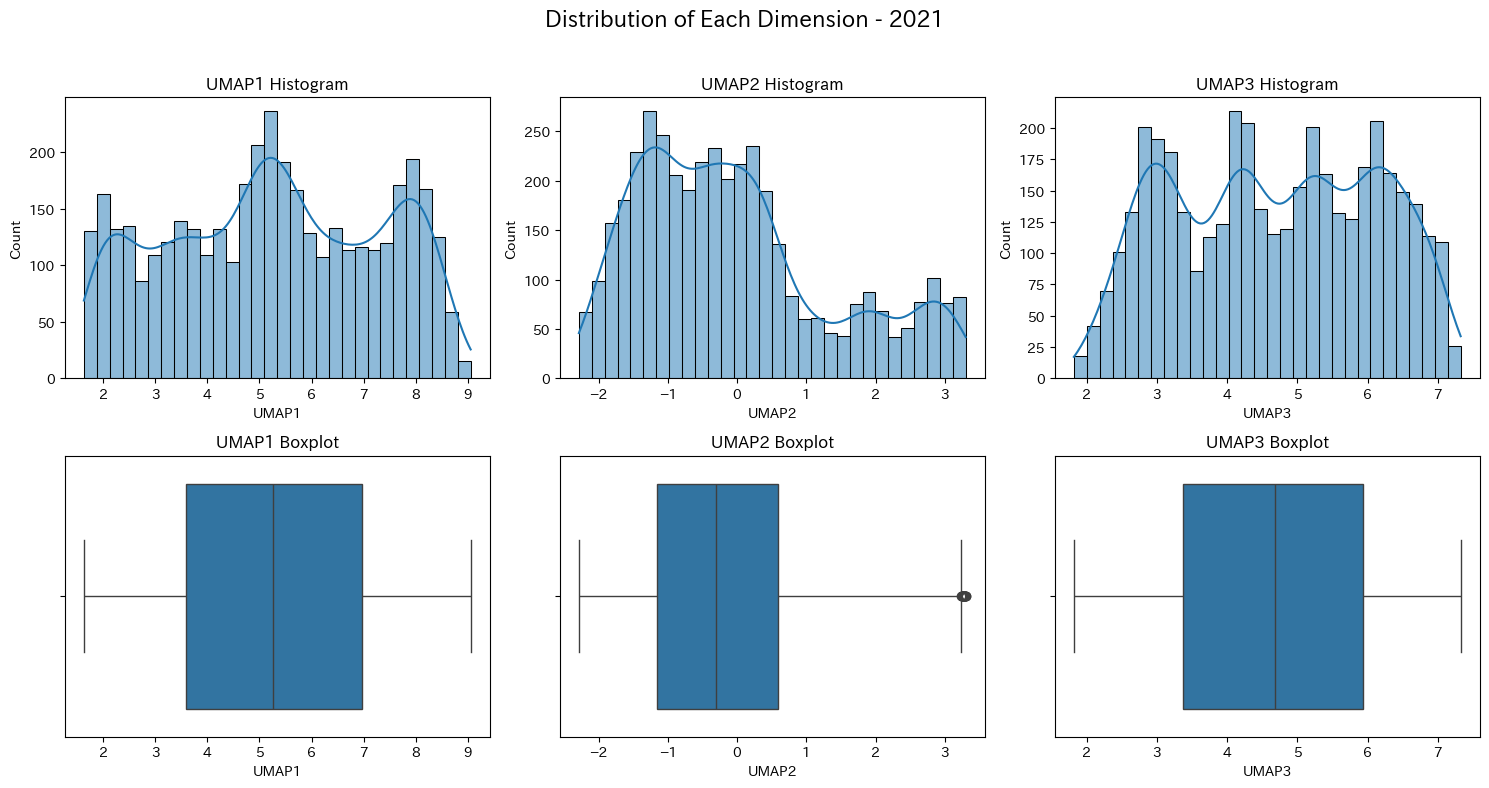

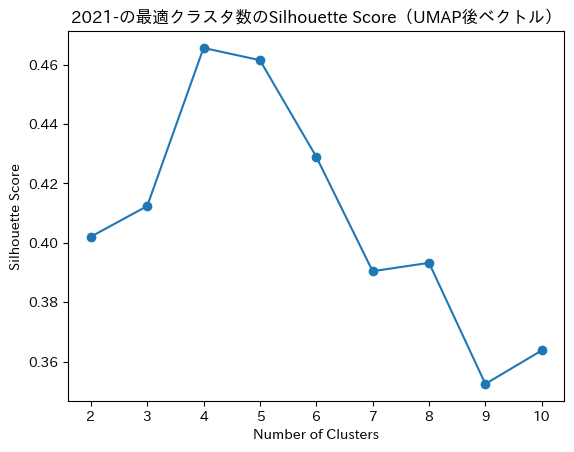

In [ ]:
journal_colors = {
    'SciMet': '#000080',  # ネイビー
    'SSS': '#ff7f0e',  # オレンジ
    'RePoli': '#2ca02c',  # 緑
    'STHV': '#d62728',  # 赤
    'TechNov': '#9467bd',  # 紫
    'PUS': '#8c564b',  # 茶
    'Minerva': '#e377c2',  # ピンク
    'SciCom': '#7f7f7f',  # グレー
    'SasC': '#bcbd22',  # 黄緑
    'ReEval': '#17becf',  # 水色
    'STS': '#ff9896',  # ピンク
    'JRI': '#1f77b4',  # 青
    'EASTS': '#ffbb78',  # ピーチ
    'TIS': 'teal',  # ディール
    'SPP': 'olive',  # オリーブ
    'JCOM': 'darkolivegreen'  # ダークグリーン
}

# データの設定
years = [1991, 1996, 2001, 2006, 2011, 2016, 2021]
test_dfs = []

# 単語の頻度を計算


# ①～⑧の処理を順番に行うループ
for num, test_df in enumerate(test_df_lst):

    # (1) 単語の頻度を計算
    word_counts = Counter(word for sentence in train_sentences for word in sentence)
    total_words = sum(word_counts.values())
    test_sentences = [text.split() for text in test_df['text_strings']]

    # (2) FastTextを用いてベクトル化
    fasttext_vectors = []
    for sentence in test_sentences:
        vecs = []
        weights = []
        for word in sentence:
            if word in fasttext_model.wv:
                vecs.append(fasttext_model.wv[word])
                weights.append(sif_weight(word))
        if vecs:
            vecs = np.array(vecs)
            weights = np.array(weights)
            weighted_vecs = np.dot(weights, vecs) / weights.sum()
            fasttext_vectors.append(weighted_vecs)
        else:
            fasttext_vectors.append(np.mean(fasttext_model.wv.vectors, axis=0))

    # (3) ベクトルの標準化
    vectors_scaled = np.array(fasttext_vectors)
    scaler = StandardScaler()
    vectors_scaled = scaler.fit_transform(fasttext_vectors)


    # (4) UMAPを用いて次元削減（可視化のため） -> 3次元に圧縮
    umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric='cosine')
    umap_result = umap_model.fit_transform(vectors_scaled)


    # UMAPの結果をDataFrameに追加
    umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2', 'UMAP3'])

    # インデックスが一致しているか確認するためにreset_index
    test_df = test_df.reset_index(drop=True)

    # test_dfにUMAPの結果を追加（インデックスに基づいて結合）
    test_df[['UMAP1', 'UMAP2', 'UMAP3']] = umap_df[['UMAP1', 'UMAP2', 'UMAP3']]



    # (5) 四分位範囲（IQR）に基づいて外れ値除去
    # 各次元のQ1（第1四分位）とQ3（第3四分位）を計算し、IQRを算出
    Q1 = umap_df.quantile(0.25)
    Q3 = umap_df.quantile(0.75)
    IQR = Q3 - Q1

    # IQRの1.5倍よりも外にあるデータ点を外れ値として除去
    filtered_df = umap_df[~((umap_df < (Q1 - 1.5 * IQR)) | (umap_df > (Q3 + 1.5 * IQR))).any(axis=1)]
    filtered_vectors = filtered_df.values

    # 外れ値を除去した後のDataFrameを元のtest_dfに統合
    test_df = test_df.iloc[filtered_df.index]

    # ⑥ 各次元ごとのヒストグラムと外れ値除去の図を保存
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'Distribution of Each Dimension - {years[num]}', fontsize=16)

    for i, dim in enumerate(['UMAP1', 'UMAP2', 'UMAP3']):
        sns.histplot(test_df[dim], bins=30, kde=True, ax=axes[0, i])
        axes[0, i].set_title(f'{dim} Histogram')
        sns.boxplot(x=test_df[dim], ax=axes[1, i])  # 修正点：x=test_df[dim] に変更
        axes[1, i].set_title(f'{dim} Boxplot')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'umap_fasttext{years[num]}_hist.png')  # ファイルを保存
    plt.show()




    # (6) K-means++によるクラスタリング（UMAP後のベクトルを使用）
    cluster_range = range(2, 11)
    silhouette_scores = []
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++')
        cluster_labels = kmeans.fit_predict(filtered_vectors)
        silhouette_avg = silhouette_score(filtered_vectors, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Silhouette Scoreをプロットして、最適クラスタ数を確認
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.title(f'{years[num]}-の最適クラスタ数のSilhouette Score（UMAP後ベクトル）')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(cluster_range)
    plt.savefig(f'Silhouette Score_{years[num]}.png')
    plt.show()




    # 最適クラスタ数を取得し、クラスタリング実行
    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, init='k-means++')
    cluster_labels = kmeans.fit_predict(filtered_vectors)
    test_df['cluster'] = cluster_labels



    # ⑦ Journal Nameごとの色分けで可視化し、HTML形式で保存
    fig1 = go.Figure()
    for journal_name, color in journal_colors.items():
        df = test_df[test_df['journal_name'] == journal_name]
        fig1.add_trace(go.Scatter3d(
            x=df['UMAP1'], y=df['UMAP2'], z=df['UMAP3'],
            mode='markers', marker=dict(size=5, color=color), name=journal_name
        ))
    if num != 6:
      fig1.update_layout(title=f"ジャーナル名による色分け({years[num]}-{years[num]+4}(ベクトル)", height=800)
    else:
      fig1.update_layout(title=f"ジャーナル名による色分け({years[num]}-{years[num]+3}(ベクトル)", height=800)

    pio.write_html(fig1, file=f'umap_fasttext{years[num]}_journal.html', auto_open=False)
    fig1.show()



    # ⑧ クラスタリング結果の可視化し、HTML形式で保存
    if num != 6:
      fig2 = px.scatter_3d(test_df, x='UMAP1', y='UMAP2', z='UMAP3', color='cluster', title=f"クラスタリング({years[num]}-{years[num]+4})")
    else:
      fig2 = px.scatter_3d(test_df, x='UMAP1', y='UMAP2', z='UMAP3', color='cluster', title=f"クラスタリング({years[num]}-{years[num]+3})")

    fig2.update_layout(height=800)
    pio.write_html(fig2, file=f'umap_fasttext{years[num]}_cluster.html', auto_open=False)
    fig2.show()


    # 結果をリストに追加
    test_dfs.append(test_df)

# 各年のデータを JSON ファイルとして保存
target_cols = ['id', 'title', 'publication_year', 'journal_name','text_strings', 'UMAP1', 'UMAP2', 'UMAP3', 'cluster']
for num, df in enumerate(test_dfs):
    df[target_cols].to_json(f"{years[num]}_vectlized.json", orient="records")
